## Setup the requirements

In [1]:
!pip install torch torchaudio torchvision mlflow dagshub

In [2]:
import os
import json

# Load token from JSON
with open('/content/youtube_dagshub.json', 'r') as f:
    youtube_dagshub_token = json.load(f)

# Set environment variable
os.environ["DAGSHUB_TOKEN"] = youtube_dagshub_token["youtube_dagshub"]


In [3]:
import mlflow
import dagshub
import json

# Load JSON from file
with open('/content/youtube_dagshub.json', 'r', encoding='utf-8') as f:
    token = json.load(f)

DAGSHUB_USER="Prayesh13"
DAGSHUB_REPO="youtube-comments-analysis"


mlflow.set_tracking_uri(f"https://dagshub.com/{DAGSHUB_USER}/{DAGSHUB_REPO}.mlflow")
dagshub.auth.add_app_token(token['youtube_dagshub'])
dagshub.init(repo_owner='Prayesh13', repo_name='youtube-comments-analysis', mlflow=True, )

with mlflow.start_run() as run:
    # Log a parameter (key-value pair)
    mlflow.log_param("param1", 5)

    # Log a metric; metrics can be updated throughout the run
    mlflow.log_metric("metric1", 0.91)

Accessing as Prayesh13

Initialized MLflow to track repo "Prayesh13/youtube-comments-analysis"

Repository Prayesh13/youtube-comments-analysis initialized!

🏃 View run resilient-dove-447 at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/0/runs/9148e2200550407e89c161905dfbb680
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/0


## Baseline Model

In [4]:
import numpy as np
import pandas as pd
import os

import mlflow
import mlflow.sklearn
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Step 1: Load the Processed dataset

df = pd.read_csv("/content/sentiment_processed.csv")



### Bi - LSTM Model

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
X = df['content']
y = df['label']
y = y + 1

y = y.astype(int)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
import re
from collections import Counter

# Custom tokenizer using regex (no downloads required)
def tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

# Build vocabulary manually
def build_vocab(texts, min_freq=1):
    counter = Counter()
    for text in texts:
        counter.update(tokenizer(text))
    vocab = {"<unk>": 0, "<pad>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# Usage
print("Building vocabulary...")
vocab = build_vocab(X_train)
print(f"Vocabulary size: {len(vocab)}")


Building vocabulary...
Vocabulary size: 101852


In [10]:
mlflow.set_experiment("LSTM_Text_Classification")

<Experiment: artifact_location='mlflow-artifacts:/02ca759d4d84448baac8a9432ef1b410', creation_time=1744814347543, experiment_id='2', last_update_time=1744814347543, lifecycle_stage='active', name='LSTM_Text_Classification', tags={}>

In [11]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer, max_len=100):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.tokenizer(self.texts[idx])
        ids = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens][:self.max_len]
        ids += [self.vocab["<pad>"]] * (self.max_len - len(ids))
        return torch.tensor(ids), torch.tensor(self.labels[idx])

# DataLoader
print("Preparing DataLoaders...")
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), vocab, tokenizer)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), vocab, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Preparing DataLoaders...


In [12]:
# BiLSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # hidden_dim * 2 because of bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        # hidden shape: (num_layers * num_directions, batch_size, hidden_dim)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # Concatenate last forward & backward hidden states
        return self.fc(hidden)


In [13]:
print(y_train.unique())
print(y_test.unique())

device = torch.device('cpu')  # 👈 debug on CPU first!

[2 1 0]
[1 2 0]


Starting training...

Epoch 1 Completed | Avg Loss: 0.4959
Epoch 2 Completed | Avg Loss: 0.2792
Epoch 3 Completed | Avg Loss: 0.2037
Epoch 4 Completed | Avg Loss: 0.1450
Epoch 5 Completed | Avg Loss: 0.0955
Starting evaluation...


Test Accuracy: 0.8956

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      8791
           1       0.90      0.93      0.91     13494
           2       0.92      0.90      0.91     17609

    accuracy                           0.90     39894
   macro avg       0.89      0.89      0.89     39894
weighted avg       0.90      0.90      0.90     39894



2025/04/18 03:59:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 03:59:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/18 03:59:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Bi-LSTM Baseline at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/4/runs/569d3b0dcd5742f18e3b603f6d9bd59c
🧪 View experiment at: https://dagshub.com/Prayesh13/youtube-comments-analysis.mlflow/#/experiments/4


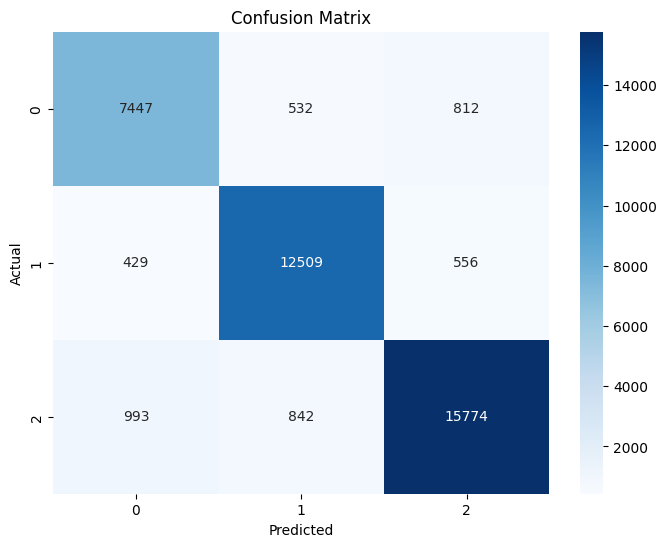

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow
import mlflow.pytorch

mlflow.set_experiment("Baseline Experiment")
with mlflow.start_run(run_name="Bi-LSTM Baseline"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vocab_size = len(vocab)
    embed_dim = 150
    hidden_dim = 128
    output_dim = y_train.nunique()

    model = BiLSTMModel(vocab_size, embed_dim, hidden_dim, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Log hyperparameters
    mlflow.log_param("vocab_size", vocab_size)
    mlflow.log_param("embed_dim", embed_dim)
    mlflow.log_param("hidden_dim", hidden_dim)
    mlflow.log_param("output_dim", output_dim)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 5)

    print("Starting training...\n")
    for epoch in range(1, 6):
        model.train()
        total_loss = 0
        batch_count = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_batch = y_batch.long()

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_count += 1
        avg_loss = total_loss / batch_count
        print(f"Epoch {epoch} Completed | Avg Loss: {avg_loss:.4f}")
        mlflow.log_metric("train_loss", avg_loss, step=epoch)

    print("Starting evaluation...\n")
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_loader):
            X_batch = X_batch.to(device)
            output = model(X_batch)
            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    mlflow.log_metric("test_accuracy", accuracy)

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, output_dict=True)
    print(classification_report(all_labels, all_preds))

    # Log each metric separately to MLflow
    for label, metrics in report.items():
        if isinstance(metrics, dict):  # skip 'accuracy' because it's not a dict
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Save and log the model
    mlflow.pytorch.log_model(model, "models/lstm_model")


In [15]:
print("y_train unique:", np.unique(y_train))
print("y_test unique:", np.unique(y_test))
print("output_dim:", output_dim)
print("y_train dtype:", y_train.dtype)
print("y_test dtype:", y_test.dtype)


y_train unique: [0 1 2]
y_test unique: [0 1 2]
output_dim: 3
y_train dtype: int64
y_test dtype: int64
